In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts
import copy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.atario import fill_resonance_ladder
from ATARI.utils.stats import chi2_val
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.theory.experimental import xs_2_trans, trans_2_xs
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions


from scipy import integrate
import functions as fn 
import classes as cls


In [2]:
%matplotlib widget

In [3]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Elam = 2000.0
E_min_max = [np.max([Elam-20, 1.0]), Elam+20]
energy_grid = E_min_max
input_options = {'Add Noise': True,
                'Calculate Covariance': False,
                'Compression Points':[],
                'Grouping Factors':None}

# experiment_parameters = {'bw': {'val':0.8192,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}
# experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}
experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}


exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)

# for Gg_DOF in [10,50,100,1000,10000]:
Gg_DOF = 10

from ATARI.theory import scattering_params
shift, penetration, phi, k = scattering_params.FofE_explicit([1,500], ac, M, m, 0)
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= 2, #np.mean(penetration)*2*46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)


spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   
# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

# xs_tot, xs_scat, xs_cap = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
# n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)
# trans = np.exp(-n*xs_tot)
# theoretical_df = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':trans})
# exp.run(theoretical_df)

# # build experimental parameters
# builder_exp_par = BuildExperimentalParameters_fromDIRECT(0.067166, 0, 1e-2)
# exp_par = builder_exp_par.construct()

# # build theoretical parameters
# builder_theo_par = BuildTheoreticalParameters_fromATARI('true', resonance_ladder, Ta_pair)
# theo_par = builder_theo_par.construct()

# # build pointwise data
# builder_pw = BuildPointwiseContainer_fromATARI(exp.trans)
# pw = builder_pw.construct_lite_w_CovT()
# pw.add_model(theo_par, exp_par) 

# # build data container
# builder_dc = BuildDataContainer_fromOBJECTS(pw, exp_par, [theo_par])
# dc = builder_dc.construct()
# # dc.pw.add_model(theo_par, exp_par)
# dc.pw.fill_exp_xs(dc.experimental_parameters)


In [4]:
np.mean(penetration)*2*46.4

1.9245872383329283

In [5]:
# figure()
# # plot(pw.fine.E, pw.fine.theo_xs)
# plot(dc.pw.exp.E, dc.pw.exp.true_xs)
# errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# yscale('log')

In [23]:

import numpy as np
import pandas as pd
import scipy.stats as sts

from scipy.linalg import block_diag
from numpy.linalg import inv

from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat

from operator import itemgetter
from itertools import groupby

from classes import FeatureBank

# ================================================================================================
# Functions for setting up the feature bank and constriants
# ================================================================================================

def get_parameter_grid(energy_grid, res_par_avg, num_Er, num_Gt, option=0):

    # allow Elambda to be just outside of the window
    max_Elam = max(energy_grid) + res_par_avg['Gt99']*1e-3
    min_Elam = min(energy_grid) - res_par_avg['Gt99']*1e-3

    if option < 2:
        num_Gn = 1
        Gn = np.array([1])
    else:
        num_Gn = num_Gt
        Gn = np.logspace(np.log10(res_par_avg['Gn01']), np.log10(res_par_avg['Gn99']), num_Gn)
                
    Er = np.linspace(              min_Elam,              max_Elam,                num_Er)
    Gt = np.logspace(np.log10(res_par_avg['Gt01']), np.log10(res_par_avg['Gt99']), num_Gt)    
    
    return Er, Gt, Gn

def get_resonance_ladder_from_parameter_grid(Er_list, Gt_list, Gn_list):
    Er_list = np.array(Er_list); num_Er = len(Er_list)
    Gt_list = np.array(Gt_list); num_Gt = len(Gt_list)
    Gn_list = np.array(Gn_list); num_Gn = len(Gn_list)

    Gn_matrix = np.tile(Gn_list, num_Gt*num_Er)
    Gt_matrix = np.tile(np.repeat(Gt_list, num_Gn), num_Er)
    Er_matrix = np.repeat(Er_list, num_Gt*num_Gn)

    resonance_ladder_array = np.column_stack((Er_matrix, Gt_matrix, Gn_matrix))
    return resonance_ladder_array


def get_feature(E, Res, particle_pair, kinematic_constant, phi, lwave, P):
    Elam=Res[0]; Gtot=Res[1]*1e-3; Gn=Res[2]*1e-3
    _, PElam, _, _ = FofE_recursive([Elam], particle_pair.ac, particle_pair.M, particle_pair.m, lwave)
    PPElam = P/PElam
    # A_column =  kinematic_constant * Gtot * ( Gtot*PPElam**2*np.cos(2*phi) /4 /((Elam-E)**2+(Gtot*PPElam/2)**2) 
    #                                         -(Elam-E)*PPElam*np.sin(2*phi) /2 /((Elam-E)**2+(Gtot*PPElam/2)**2) )  
    A_column =  kinematic_constant*Gn* ( Gtot*PPElam**2*np.cos(2*phi) /4 /((Elam-E)**2+(Gtot*PPElam/2)**2) 
                                    - (Elam-E)*PPElam*np.sin(2*phi) /2 /((Elam-E)**2+(Gtot*PPElam/2)**2) )  
    return A_column
            
def get_feature_bank_from_resonance_ladder(E, particle_pair, resonance_ladder_array, solver, sammy_RTO=None):
    E = np.sort(np.array(E))
    number_of_resonances = len(resonance_ladder_array)
    Resonance_Matrix = np.zeros((len(E), number_of_resonances))

    lwave = 0
    _, P, phi, k = FofE_recursive(E, particle_pair.ac, particle_pair.M, particle_pair.m, lwave)
    g = gstat(3.0, particle_pair.I, particle_pair.i)
    kinematic_constant = (4*np.pi*g/k**2)
    potential_scattering = kinematic_constant * np.sin(phi)**2 

    if solver == "syndat_SLBW":
        for iRes, Res in enumerate(resonance_ladder_array):
            Resonance_Matrix[:, iRes] = get_feature(E, Res, particle_pair, kinematic_constant, phi, lwave, P)

    elif solver == "sammy":
        if sammy_RTO is None:
            raise ValueError(f"Solver selected: {solver} but user did not pass sammy_RTO")
        else:
            for iRes, Res in enumerate(resonance_ladder_array):
                sammyINP = sammy_classes.SammyInputData(particle_pair = particle_pair, resonance_ladder =pd.DataFrame([np.append(Res,[3.0,1,0,1])], columns=["E","Gt","Gn","J","chs","lwave","J_ID"], index=[0]),
                                                        energy_grid=E, temp = 304.5, FP=35.185, frac_res_FP=0.049600, target_thickness=0.067166)
                sammyOUT = sammy_functions.run_sammy(sammyINP, sammy_RTO)
                pw = sammyOUT.pw
                if sammy_RTO.reaction == "total" or sammy_RTO.reaction == "transmission":
                    Resonance_Matrix[:, iRes] = pw.theo_xs.values-potential_scattering.flatten()
                else:
                    Resonance_Matrix[:, iRes] = pw.theo_xs.values
    else:
        raise ValueError(f"Solver: {solver} not recognized")

    return Resonance_Matrix, potential_scattering.flatten(), E


## Set parameter grid and generate resonances at different Gn and Gt to compare 

Max xs value describes the maximum cross section you could see in a transmission experiment. A threshold for transmission was set to 0.001 and the thickness used was 0.005 atoms/bn corresonding to about 0.1cm thick via: (0.005*181/10**-24/(6.022e23)/16.65). Jesse's work used 0.00566 and 0.06716 a/bn for evaluation and validation measurements respectively.

In [27]:
# E1 = np.linspace(99,101,1000)
E1 = np.sort(exp.energy_domain)
ipar = 10
Er_list, Gt_list, Gn_list = get_parameter_grid(E1, res_par_avg, 1, ipar, option=2)
Er_list = [Elam]
iElam = np.searchsorted(E1, Elam)

resonance_ladder_array = get_resonance_ladder_from_parameter_grid(Er_list, Gt_list, Gn_list)

# maxxs, _ = trans_2_xs(0.01, 0.005)
maxxs, _ = trans_2_xs(0.01, 0.00566)
print(Gt_list)
print(Gn_list)
# resonance_ladder_array

[ 16.372872    21.11868369  27.24010794  35.13587739  45.32030059
  58.45676267  75.40093638  97.25651827 125.44712044 161.80900062]
[3.14175716e-04 1.02597869e-03 3.35045714e-03 1.09413219e-02
 3.57302060e-02 1.16681297e-01 3.81036847e-01 1.24432178e+00
 4.06348282e+00 1.32697932e+01]


array([[2.00000000e+03, 1.63728720e+01, 3.14175716e-04],
       [2.00000000e+03, 1.63728720e+01, 1.02597869e-03],
       [2.00000000e+03, 1.63728720e+01, 3.35045714e-03],
       [2.00000000e+03, 1.63728720e+01, 1.09413219e-02],
       [2.00000000e+03, 1.63728720e+01, 3.57302060e-02],
       [2.00000000e+03, 1.63728720e+01, 1.16681297e-01],
       [2.00000000e+03, 1.63728720e+01, 3.81036847e-01],
       [2.00000000e+03, 1.63728720e+01, 1.24432178e+00],
       [2.00000000e+03, 1.63728720e+01, 4.06348282e+00],
       [2.00000000e+03, 1.63728720e+01, 1.32697932e+01],
       [2.00000000e+03, 2.11186837e+01, 3.14175716e-04],
       [2.00000000e+03, 2.11186837e+01, 1.02597869e-03],
       [2.00000000e+03, 2.11186837e+01, 3.35045714e-03],
       [2.00000000e+03, 2.11186837e+01, 1.09413219e-02],
       [2.00000000e+03, 2.11186837e+01, 3.57302060e-02],
       [2.00000000e+03, 2.11186837e+01, 1.16681297e-01],
       [2.00000000e+03, 2.11186837e+01, 3.81036847e-01],
       [2.00000000e+03, 2.11186

In [26]:
sammyRTO_cap = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'capture',
    inptemplate = 'allexpcap_1sg.inp',
    # sammy_runDIR = 'SAMMY_runDIR_1',
    shell = 'zsh',
    keep_runDIR = True
    )

sammyRTO_tot = copy.copy(sammyRTO_cap)
sammyRTO_tot.reaction = 'total'

resonance_bank_cap, pscat_cap, E_cap = get_feature_bank_from_resonance_ladder(E1, 
                                                            Ta_pair, 
                                                            resonance_ladder_array,
                                                             "sammy", sammy_RTO=sammyRTO_cap)
                                                            # "syndat_SLBW")

resonance_bank_tot, pscat_tot, E_tot = get_feature_bank_from_resonance_ladder(E1, 
                                                            Ta_pair, 
                                                            resonance_ladder_array,
                                                             "sammy", sammy_RTO=sammyRTO_tot)
                                                            # "syndat_SLBW")

In [ ]:
# filter_black_res = False
# if filter_black_res:
#     resonance_bank_broadened = resonance_bank_tot.copy()
#     resonance_bank_broadened[resonance_bank_broadened>maxxs] = maxxs
# else:
#     resonance_bank_broadened = resonance_bank_tot.copy()

norm_cap = np.atleast_2d(np.linalg.norm(resonance_bank_cap, axis=0))
sim_cap =  np.dot(resonance_bank_cap.T,resonance_bank_cap)/(norm_cap.T @ norm_cap)

norm_tot = np.atleast_2d(np.linalg.norm(resonance_bank_tot, axis=0))
sim_tot =  np.dot(resonance_bank_tot.T,resonance_bank_tot)/(norm_tot.T @ norm_tot)

# ISE = np.zeros_like(sim_broadened)
# MAD = np.zeros_like(sim_broadened)
# MaxAD = np.zeros_like(sim_broadened)
# for i1 in range(ipar**2):
#     for i2 in range(ipar**2):
#         ratio = resonance_bank_broadened[:,i2]/resonance_bank_broadened[:,i1]
#         ISE[i1, i2] = integrate.trapezoid( (resonance_bank_broadened[:,i2]-resonance_bank_broadened[:,i1]*ratio[iElam])**2, E_broadened)
#         MAD[i1, i2] = np.median(abs((resonance_bank_broadened[:,i2]-resonance_bank_broadened[:,i1]*ratio[iElam])))
#         MaxAD[i1, i2] = np.max(abs((resonance_bank_broadened[:,i2]-resonance_bank_broadened[:,i1]*ratio[iElam])))

## Verify with SLBW

In [ ]:

### No Broadening
# sammyRTO.experimental_corrections = 'no_exp'
# resonance_bank_0, pscat, E = get_feature_bank_from_resonance_ladder(E1, 
#                                                             Ta_pair, 
#                                                             resonance_ladder_array,
#                                                              "sammy", sammy_RTO=sammyRTO)
#                                                             # "syndat_SLBW")

# filter_black_res = False
# if filter_black_res:
#     resonance_bank = resonance_bank_0.copy()
#     resonance_bank[resonance_bank>maxxs] = maxxs
# else:
#     resonance_bank = resonance_bank_0.copy()   

# norm = np.atleast_2d(np.linalg.norm(resonance_bank, axis=0))
# sim =  np.dot(resonance_bank.T,resonance_bank)/(norm.T @ norm)                                        
# figure()
# imshow(sim)

# ax=gca()
# ax.set_xticks(np.arange(-0.5, len(resonance_ladder_array)-0.5, ipar))
# ax.set_yticks(np.arange(-0.5, len(resonance_ladder_array)-0.5, ipar))
# ax.set_xticklabels(np.arange(0, len(resonance_ladder_array), ipar))
# ax.set_yticklabels(np.arange(0, len(resonance_ladder_array), ipar))
# ax.grid(color='red', linestyle='-.', linewidth=1)

# colorbar()


# ### Individual resonance
# i1 = 70
# i2 = 79
# ratio = resonance_bank[:,i2]/resonance_bank[:,i1]
# approx = resonance_bank[:,i1]*ratio[iElam] #np.mean(ratio)
# exact = resonance_bank[:,i2]
# if filter_black_res:
#     approx[approx>maxxs] = maxxs


# fig, ax = subplots(1,2, figsize=(10, 4), sharex=True)

# # ax[1].plot(E, ratio/exact)
# # ax[1].set_title("Ratio")
# ax[1].plot(E, 100*(exact-approx)/exact)
# ax[1].set_title("% Diff")
    
# ax[0].plot(E, approx, 'r')
# ax[0].plot(E, exact, 'b')
# ax[0].set_title("Scaled Shape Comparison")

# if np.max([approx,exact]) > maxxs:
#     ax[0].axhline(maxxs, color='purple', label=("Blackout"))

# # ax[0].set_ylim([-0.5, 0.5])
# legend()
# tight_layout()

## Broadened cross sections

In [ ]:
# print(np.argmax(np.sum(sim_broadened, axis=1)))
print(np.argmax(np.median(sim_cap, axis=1)))
print(np.argmax(np.min(sim_cap, axis=1)))
print(np.argmax(np.average(sim_cap, axis=1)))

print(np.argmax(np.median(sim_tot, axis=1)))
print(np.argmax(np.min(sim_tot, axis=1)))
print(np.argmax(np.average(sim_tot, axis=1)))

imin_cap1, imin_cap2 = np.unique(np.argwhere(sim_cap == np.min(sim_cap)).flatten())
imin_tot1, imin_tot2 = np.unique(np.argwhere(sim_tot == np.min(sim_tot)).flatten())

30
72
60
67
81
62


In [ ]:
np.any(resonance_bank_tot<=0)

True

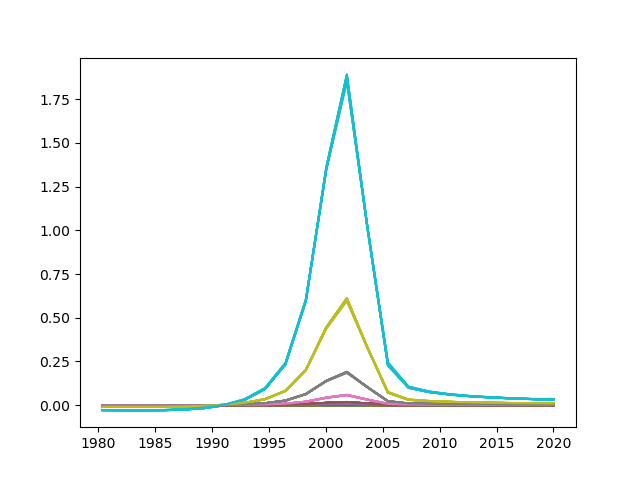

In [ ]:
figure()
out = plot(E1, resonance_bank_tot)
# out = plot(E1, resonance_bank_cap)

Text(0.5, 1.0, 'total')

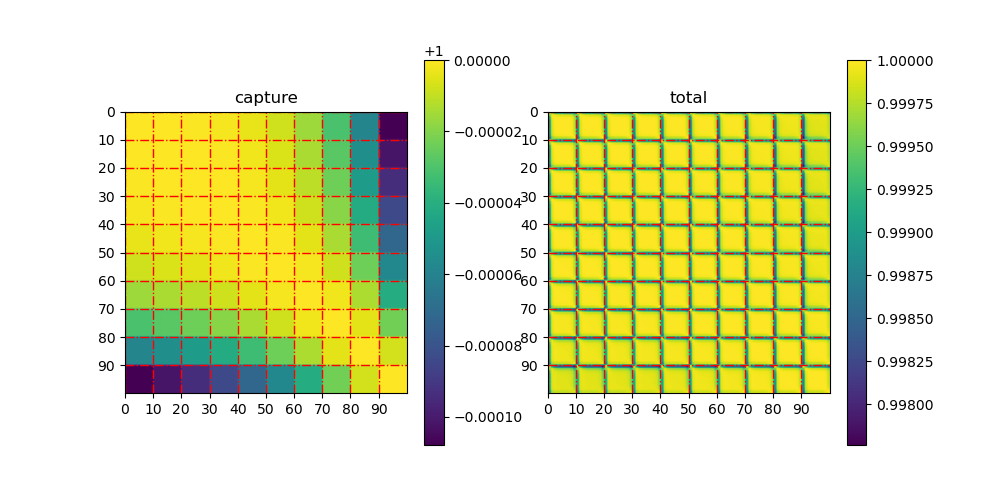

In [ ]:
fig, axes = subplots(1,2, figsize=(10,5))

im1 = axes[0].imshow(sim_cap)
im2 = axes[1].imshow(sim_tot)

for ax, im in zip(axes, [im1, im2]):
    ax.set_xticks(np.arange(-0.5, len(resonance_ladder_array)-0.5, ipar))
    ax.set_yticks(np.arange(-0.5, len(resonance_ladder_array)-0.5, ipar))
    ax.set_xticklabels(np.arange(0, len(resonance_ladder_array), ipar))
    ax.set_yticklabels(np.arange(0, len(resonance_ladder_array), ipar))
    ax.grid(color='red', linestyle='-.', linewidth=1)
    fig.colorbar(im, ax=ax)

axes[0].set_title("capture")
axes[1].set_title("total")

In [ ]:
from scipy.optimize import minimize

def get_lsw(approx, exact):
    data = exact
    data_unc = np.sqrt(abs(data))
    data_unc = (data_unc)*0.001
    data_unc = np.ones_like(data)*1e-6

    def f(x):
        # return np.sum(((approx*x-data)/data_unc)**2)
        return np.sum(((approx*x-data))**2)
    
    out = minimize(f, x0=1)
    return out.x, data, data_unc


def get_GnGt(i):
    iGn = (i % ipar)
    iGt = int((i-iGn)/ipar)

    Gn = Gn_list[iGn]
    Gt = Gt_list[iGt]
    return Gn, Gt

def get_weighted_GnGt():
    return None

# def fcap(x):
#     return (np.pi*g/k**2) * x[0]*x[1]/((x[0]+x[1])**2/4)

# def fcap_diff(x):
#     return fcap(x) - eq_cap

# def ftot(x):
#     Gt = x[0]+x[1]
#     d = (x[0]+x[1])**2/4
#     return pscat_tot[iElam] + (4*np.pi*g/k**2) * Gt*x[1]/(4*d)*np.cos(2*phi)
# def ftot_diff(x):
#     return ftot(x) - eq_tot


# def func(x):
#     return [fcap_diff(x).item(),
#             ftot_diff(x).item()]
# root = fsolve(func, np.array([10.729550169585446, 16.372811858102295])*1e-3, full_output = True, maxfev=1000)

# def fct(x):
#     # sammyINP = sammy_classes.SammyInputData(particle_pair       = Ta_pair, 
#     #                                     resonance_ladder    = pd.DataFrame([np.append([Elam, x[0], x[1]],[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]),
#     #                                     energy_grid   = E_cap, #[E_cap[iElam]],
#     #                                     initial_parameter_uncertainty = 0.1)

#     # pw_cap, par_cap = sammy_functions.run_sammy(sammyINP, sammyRTO_cap)
#     # pw_tot, par_tot = sammy_functions.run_sammy(sammyINP, sammyRTO_tot)
#     # tot = pw_tot.theo_xs[iElam]
#     # cap = pw_cap.theo_xs[iElam]
    
#     tot, _, cap = SLBW([E_cap[iElam]], Ta_pair, pd.DataFrame([np.append([Elam, x[0], x[1]],[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))#[2]
#     return list(np.append(tot-approx_tot[iElam], cap-approx_cap[iElam]))
# root = fsolve(fct, np.array([10.729550169585446, 16.372811858102295]), full_output = True, maxfev=1000)

#### Failing cases
I beleive that most cases that do not converge are falling victim to the Gg running away problem. 
I want to investigate this problem further. For example, case iest = 1, itrue = 99 for Elam 2000 and bw = 0.0256.

In [ ]:

### Individual resonances
# iest = imin_cap1 
# itrue =  imin_cap2 
# iest = imin_tot1 
# itrue =  imin_tot2 
iest = 1 
itrue =  99 

# capture
ratio_cap = resonance_bank_cap[:,itrue]/resonance_bank_cap[:,iest]
approx_cap = resonance_bank_cap[:,iest]#*ratio_cap[iElam]#np.median(ratio)
exact_cap = resonance_bank_cap[:,itrue]

# total
ratio_tot = resonance_bank_tot[:,itrue]/resonance_bank_tot[:,iest]
approx_tot = resonance_bank_tot[:,iest]#*ratio_tot[iElam]#np.median(ratio)
exact_tot = resonance_bank_tot[:,itrue]

# if sammyRTO.reaction == "total" or  sammyRTO.reaction == "transmission":
#     data = exact + pscat_broadened
# else:
#     data = exact
# data_unc = np.sqrt(data)/1000
# data_unc = (data)*0.001

### get ls weight for cap and tot
wc, dc, dc_unc = get_lsw(approx_cap, exact_cap)
wt, dt, dt_unc = get_lsw(approx_tot, exact_tot)
dt = dt + pscat_tot

approx_cap = approx_cap*wc
approx_tot = approx_tot*wt + pscat_tot
exact_tot = exact_tot + pscat_tot

Gn_true, Gt_true = get_GnGt(itrue)
Gn_est, Gt_est = get_GnGt(iest)
x_est = np.array([Gt_est-Gn_est, Gn_est])*1e-3



### Fit in no-exp space
from scipy.optimize import fsolve, least_squares

# Efit = np.array(E_cap[[iElam]])
Efit = np.array(E_cap[[iElam-1, iElam, iElam+1]], dtype=float)

lwave = 0
_, P, phi, k = FofE_recursive(Efit, Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
g = gstat(3.0, Ta_pair.I, Ta_pair.i)

def fcap(x):
    return (np.pi*g/k**2) * x[0]*x[1]/( (Efit-Elam)**2 + ((x[0]+x[1])/2)**2 )
def ftot(x):
    Gt = x[0]+x[1]
    d = (Efit-Elam)**2 + (x[0]+x[1])**2/4
    return (4*np.pi*g/k**2) * (Gt*x[1]/(4*d)*np.cos(2*phi) + (Efit-Elam)*x[1]/(2*d)*np.sin(2*phi) )

### Verify cap and tot SLBW funcitons 
# tot, _, cap = SLBW([E_cap[iElam]], Ta_pair, pd.DataFrame([np.append([Elam, Gt_est-Gn_est, Gn_est],[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))
# print(tot, cap)
# print(ftot(x_est),fcap(x_est))

def fcap_diff(x):
    return fcap(x) - fcap(x_est)*wc
def ftot_diff(x):
    return ftot(x) - ftot(x_est)*wt

# x0 = np.array([5.729550169585446, 10.372811858102295])*1e-3
# x0 = np.array([148, 10.7])*1e-3
x0 = np.array([1, 1])*1e-3

# def func(x):
#     return [fcap_diff(x).item(),
#             ftot_diff(x).item()]
# root = fsolve(func, x0, full_output = True, maxfev=1000)
# root
# Gg_fit = root[0][0]*1e3
# Gn_fit = root[0][1]*1e3

def func(x):
    return np.append(fcap_diff(x),ftot_diff(x))
ls_sol = least_squares(func, x0, bounds=(0, 10))
# ls_sol

### pull out fit
Gg_fit = ls_sol.x[0]*1e3
Gn_fit = ls_sol.x[1]*1e3

est_ladder = pd.DataFrame(np.atleast_2d(np.append(np.array([Elam, Gt_est-Gn_est, Gn_est]),[3.0,1,0,1])), columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0])
par_ladder = pd.DataFrame(np.atleast_2d(np.append([Elam, Gg_fit, Gn_fit],[3.0,1,0,1])), columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0])
true_ladder = pd.DataFrame(np.atleast_2d(np.append(np.array([Elam, Gt_true-Gn_true, Gn_true]),[3.0,1,0,1])), columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0])

### Calculate estimate, parameterized estimate, and true
sammyINP = sammy_classes.SammyInputData(particle_pair       = Ta_pair, 
                                        resonance_ladder    = est_ladder,
                                        energy_grid         =  E_cap,
                                        initial_parameter_uncertainty = 0.1)

pw_cap_est, par_cap_est = sammy_functions.run_sammy(sammyINP, sammyRTO_cap)
pw_tot_est, par_tot_est = sammy_functions.run_sammy(sammyINP, sammyRTO_tot)

sammyINP.resonance_ladder = par_ladder
pw_cap_par, par_cap_par = sammy_functions.run_sammy(sammyINP, sammyRTO_cap)
pw_tot_par, par_tot_par = sammy_functions.run_sammy(sammyINP, sammyRTO_tot)

sammyINP.resonance_ladder = true_ladder
pw_cap_true, par_cap_true = sammy_functions.run_sammy(sammyINP, sammyRTO_cap)
pw_tot_true, par_tot_true = sammy_functions.run_sammy(sammyINP, sammyRTO_tot)


### Final Bayes fit parameterized estimate to true
sammyRTO_cap_bayes = copy.copy(sammyRTO_cap)
sammyRTO_cap_bayes.solve_bayes = True
sammyRTO_cap_bayes.recursive = False
sammyRTO_cap_bayes.recursive_opt['print'] = True
sammyRTO_cap_bayes.recursive_opt['threshold'] = 1e-8
sammyRTO_cap_bayes.recursive_opt['iterations'] = 10

sammyRTO_tot_bayes = copy.copy(sammyRTO_cap_bayes)
sammyRTO_tot_bayes.reaction = 'total'

exp_df_cap = pd.DataFrame({"E":E_cap, "exp_trans":dc, "exp_trans_unc":dc_unc})
exp_df_tot = pd.DataFrame({"E":E_tot, "exp_trans":dt, "exp_trans_unc":dt_unc})

sammyINP = sammy_classes.SammyInputData(particle_pair       = Ta_pair, 
                                        resonance_ladder    = par_ladder,
                                        experimental_data   = exp_df_cap,
                                        initial_parameter_uncertainty = 0.1)

sammyINP.experimental_data = exp_df_cap
pw_cap_fit, par_cap_fit = sammy_functions.run_sammy(sammyINP, sammyRTO_cap_bayes)
sammyINP.experimental_data = exp_df_tot
pw_tot_fit, par_tot_fit = sammy_functions.run_sammy(sammyINP, sammyRTO_tot_bayes)

## View estimated fit

(1980.0, 2020.0)

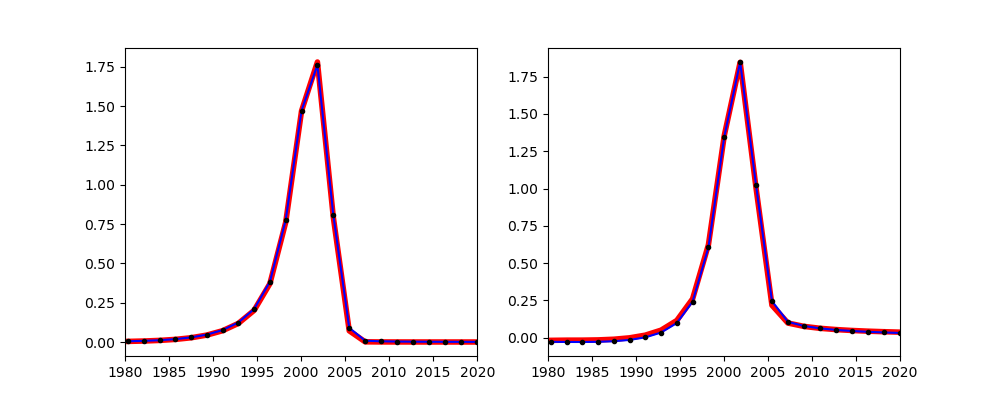

In [ ]:

fig, ax = subplots(1,2, figsize=(10, 4), sharex=True)

ax[0].plot(E_cap, approx_cap, 'r', lw=4, label='w est')
ax[0].plot(E_cap, exact_cap, 'b', label='target')
ax[0].errorbar(E_cap, dc, yerr=dc_unc, fmt='.', color='k', ecolor='k', elinewidth=2)
ax[0].set_xlim(E_min_max)

ax[1].plot(E_cap, (approx_tot-pscat_tot), 'r', lw=4, label='w est')
ax[1].plot(E_cap, exact_tot-pscat_tot, 'b', label='target')
ax[1].errorbar(E_cap, dt-pscat_tot, yerr=dt_unc, fmt='.', color='k', ecolor='k', elinewidth=2)
ax[1].set_xlim(E_min_max)

## View estimates in SLBW-noexp space

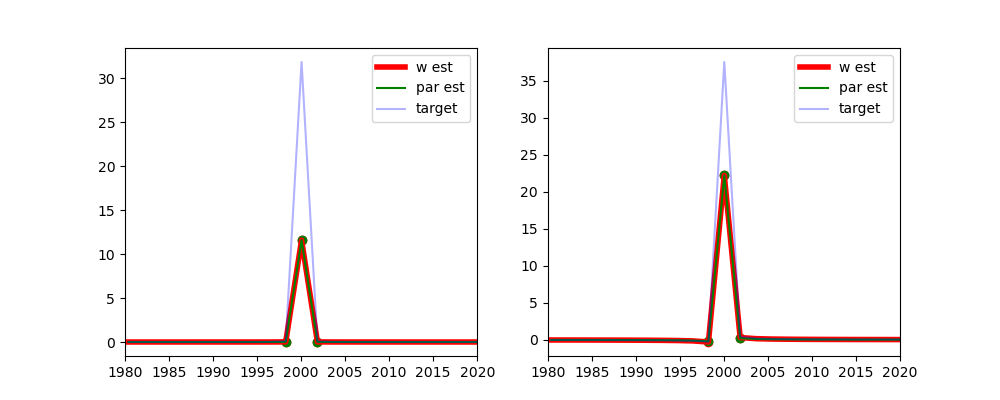

In [ ]:
tot_true, _, cap_true = SLBW(E_cap, Ta_pair, pd.DataFrame([np.append(np.array([Elam, Gt_true-Gn_true, Gn_true]),[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))
tot_est, _, cap_est = SLBW(E_cap, Ta_pair, pd.DataFrame([np.append(np.array([Elam, Gt_est-Gn_est, Gn_est]),[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))
tot_par, _, cap_par = SLBW(E_cap, Ta_pair, pd.DataFrame([np.append([Elam, Gg_fit, Gn_fit],[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))

fig, ax = subplots(1,2, figsize=(10, 4), sharex=True)

ax[0].scatter(Efit, fcap(x_est)*wc, color='r')
# ax[0].scatter(Efit, fcap(x0), color='g')
ax[0].scatter(Efit, fcap(np.array([Gg_fit, Gn_fit], dtype=float)*1e-3), color='g')

ax[0].plot(E_cap, cap_est*wc, 'r', lw=4, label='w est')
ax[0].plot(E_cap, cap_par, 'g', label='par est')
ax[0].plot(E_cap, cap_true, 'b', alpha=0.3, label='target')
ax[0].set_xlim(E_min_max)
ax[0].legend()

ax[1].scatter(Efit, ftot(x_est)*wt, color='r')
# ax[1].scatter(Efit, ftot(x0), color='g')
ax[1].scatter(Efit, ftot(np.array([Gg_fit, Gn_fit], dtype=float)*1e-3), color='g')

ax[1].plot(E_cap, (tot_est-pscat_tot)*wt, 'r', lw=4, label='w est')
ax[1].plot(E_cap, tot_par-pscat_tot, 'g', label='par est')
ax[1].plot(E_cap, tot_true-pscat_tot, 'b', alpha=0.3, label='target')
ax[1].set_xlim(E_min_max)
ax[1].legend()

## View estimates in broadened space

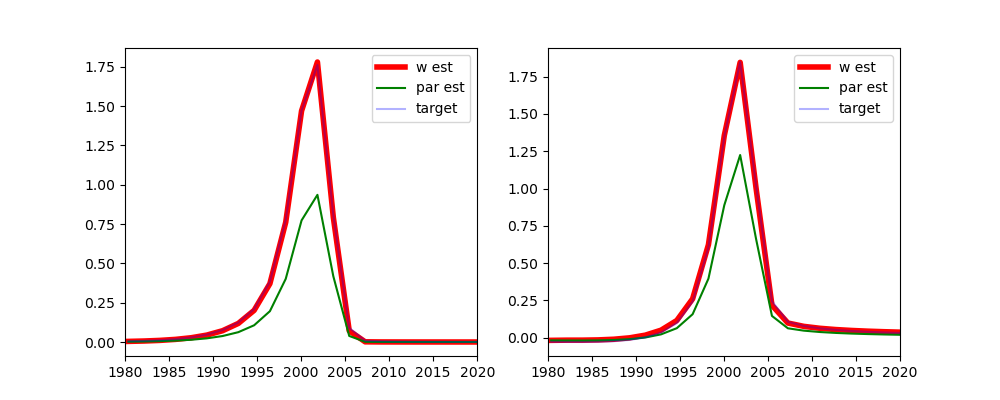

In [ ]:

# tot_true, _, cap_true = SLBW(E_cap, Ta_pair, pd.DataFrame([np.append([Elam, Gt_true-Gn_true, Gn_true],[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))
# tot_par, _, cap_par = SLBW(E_cap, Ta_pair, pd.DataFrame([np.append([Elam, 5.729550169585446, 10.372811858102295],[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))
# tot, _, cap = SLBW(E_cap, Ta_pair, pd.DataFrame([np.append([Elam, Gt_est-Gn_est, Gn_est],[3.0,1,0,1])], columns=["E","Gg","Gn","J","chs","lwave","J_ID"], index=[0]))


fig, ax = subplots(1,2, figsize=(10, 4), sharex=True)

# ax[0].scatter([E_cap[iElam]], fcap(x_est)*wc, color='r')
# # ax[0].scatter([E_cap[iElam]], fcap(x0), color='g')
# ax[0].scatter([E_cap[iElam]], fcap(root[0]), color='g')

ax[0].plot(pw_cap_est.E, pw_cap_est.theo_xs*wc, 'r', lw=4, label='w est')
# ax[0].plot(E_cap, approx_cap, 'r', lw=4)
ax[0].plot(pw_cap_par.E, pw_cap_par.theo_xs, 'g', label='par est')
ax[0].plot(pw_cap_true.E, pw_cap_true.theo_xs, 'b', alpha= 0.3, label='target')
# ax[0].plot(pw_cap_true.E, exact_cap, 'b')
ax[0].set_xlim(E_min_max)
ax[0].legend()

# ax[1].scatter([E_cap[iElam]], ftot(x_est)*wt, color='r')
# # ax[1].scatter([E_cap[iElam]], ftot(x0), color='g')
# ax[1].scatter([E_cap[iElam]], ftot(root[0]), color='g')

ax[1].plot(pw_tot_est.E, (pw_tot_est.theo_xs-pscat_tot)*wt, 'r', lw=4, label='w est')
ax[1].plot(pw_tot_par.E, pw_tot_par.theo_xs-pscat_tot, 'g', label='par est')
ax[1].plot(pw_tot_true.E, pw_tot_true.theo_xs-pscat_tot, 'b', alpha= 0.3, label='target')
ax[1].set_xlim(E_min_max)
legend()

## View final Bayes fit of parameterized estimate to true

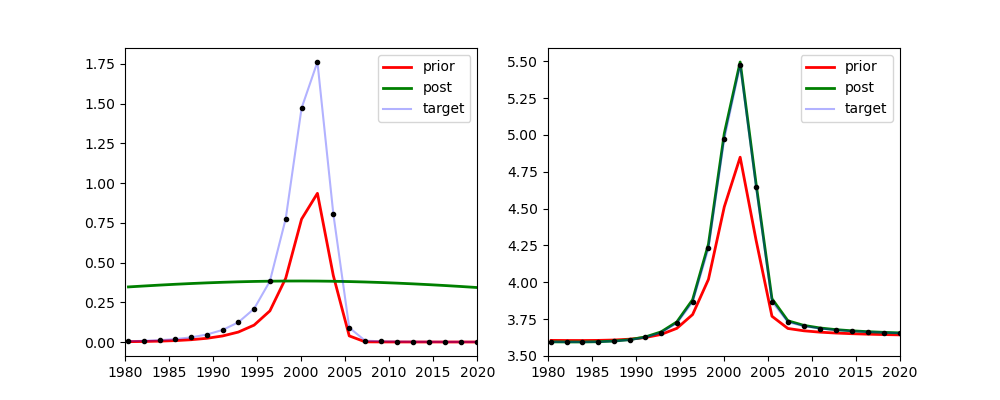

In [ ]:

fig, ax = subplots(1,2, figsize=(10, 4), sharex=True)

ax[0].plot(pw_cap_fit.E, pw_cap_fit.theo_xs, 'r', lw=2, label='prior')
ax[0].plot(pw_cap_fit.E, pw_cap_fit.theo_xs_bayes, 'g', lw=2, label='post')
ax[0].plot(pw_cap_true.E, pw_cap_true.theo_xs, 'b', alpha= 0.3, label='target')
ax[0].errorbar(pw_cap_fit.E, pw_cap_fit.exp_xs, yerr=pw_cap_fit.exp_xs_unc, color='k', fmt='.', ecolor='k', capsize=1)
ax[0].set_xlim(E_min_max)
ax[0].legend()

ax[1].plot(pw_tot_fit.E, pw_tot_fit.theo_xs, 'r', lw=2, label='prior')
ax[1].plot(pw_tot_fit.E, pw_tot_fit.theo_xs_bayes, 'g', lw=2, label='post')
ax[1].plot(pw_tot_true.E, pw_tot_true.theo_xs, 'b', alpha= 0.3, label='target')
ax[1].errorbar(pw_tot_fit.E, pw_tot_fit.exp_xs, yerr=pw_tot_fit.exp_xs_unc, color='k', fmt='.', ecolor='k', capsize=1)
ax[1].set_xlim(E_min_max)
legend()

## Need to fit all capture and total simultaneously

In [ ]:
print(par_cap_true[["Gg", "Gn1"]])#.values.flatten())
print(par_cap_fit[["Gg", "Gn1"]])#.values.flatten())
print(par_tot_fit[["Gg", "Gn1"]])#.values.flatten())


           Gg        Gn1
0  148.539207  13.269793
           Gg        Gn1
0  116393.791  77.961991
           Gg        Gn1
0  254.610406  13.627498


In [ ]:
(par_cap_true["Gg"] - par_cap_fit["Gg"]).item()
(pw_cap_true.theo_xs - pw_cap_fit.theo_xs).values

array([2.64402970e-03, 3.95089340e-03, 6.06590280e-03, 9.44531520e-03,
       1.48655976e-02, 2.36006248e-02, 3.77867884e-02, 6.13317274e-02,
       1.02987754e-01, 1.87103382e-01, 3.74546165e-01, 6.98577740e-01,
       8.26463488e-01, 3.88737185e-01, 5.18009331e-02, 7.21168500e-03,
       4.04607970e-03, 2.61195510e-03, 1.82208820e-03, 1.34703150e-03,
       1.03828170e-03, 8.25705200e-04, 6.72802900e-04])

Sammy will need to be run iteratively with a smaller prior or else Gg will run away (the most direct route to improve chi2).
Need to code up in sammy_interface:
1. the loop until chi2 criteria
2. let have the interface take a sammy formatted parameter dataframe - check upon passing in but this way it can loop over the parameters more easily

## What sort of error corresponds to a given similarity coefficient?

The following takes each resonance pair generated above and scales them s.t. they match at the peak. Then, different measures of error between the two are determined. This is conservative since any fitting algorithm would scale a feature not to match at the peak but rather around the edges.

In [ ]:
# fig, ax = subplots(1,2, figsize=(10,4))
# im1 = ax[0].imshow(np.log10(ISE))
# im2 = ax[1].imshow(np.log10(MAD))
# # im2 = ax[1].imshow(MAD)
# # im2 = ax[1].imshow(np.log10(MaxAD))
# ax[0].set_title("Log(Integral Squared Error)")
# ax[1].set_title("Log(Median Absolute Deviation)")

# fig.colorbar(im1, ax=ax[0])
# fig.colorbar(im2, ax=ax[1])

## Analyze saved data from demonstration

In [35]:
iest1_Gn_error_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_Gn_error_cap.npy')
iest1_Gg_error_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_Gg_error_cap.npy')
iest1_cap_residual_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_cap_residual_cap.npy')
iest1_Gn_error_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_Gn_error_tot.npy')
iest1_Gg_error_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_Gg_error_tot.npy')
iest1_cap_residual_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_cap_residual_tot.npy')
iest1_sim_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_sim_tot.npy')
iest1_sim_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/save_sim_cap.npy')

In [36]:
iest = 5
Gn_error_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_Gn_error_cap.npy')
Gg_error_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_Gg_error_cap.npy')
cap_residual_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_cap_residual_cap.npy')

Gn_error_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_Gn_error_tot.npy')
Gg_error_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_Gg_error_tot.npy')
cap_residual_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_cap_residual_tot.npy')

sim_tot = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_sim_tot.npy')
sim_cap = np.load(f'/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/test_GLLSconvergence/iest{iest}_sim_cap.npy')

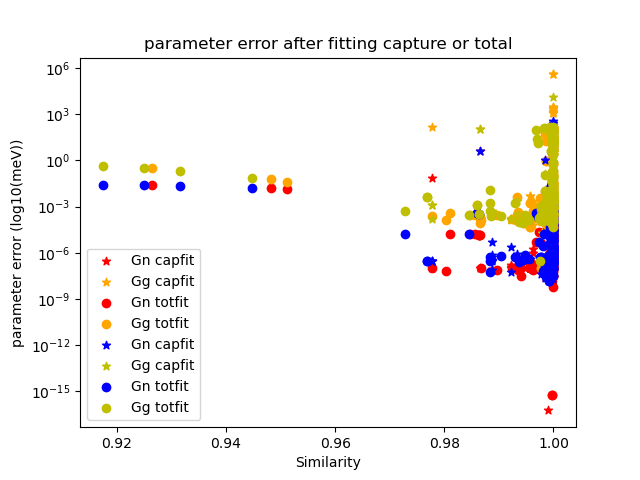

In [40]:
figure()

scatter(iest1_sim_cap, abs(iest1_Gn_error_cap+0.0000001), color='r', marker='*', label = "Gn capfit")
scatter(iest1_sim_cap, abs(iest1_Gg_error_cap+0.0000001), color='orange', marker='*', label = "Gg capfit")
scatter(iest1_sim_tot, abs(iest1_Gn_error_tot+0.0000001), color='r', label = "Gn totfit")
scatter(iest1_sim_tot, abs(iest1_Gg_error_tot+0.0000001), color='orange', label = "Gg totfit")

scatter(sim_cap, abs(Gn_error_cap+0.0000001), color='b', marker='*', label = "Gn capfit")
scatter(sim_cap, abs(Gg_error_cap+0.0000001), color='y', marker='*', label = "Gg capfit")

scatter(sim_tot, abs(Gn_error_tot+0.0000001), color='b', label = "Gn totfit")
scatter(sim_tot, abs(Gg_error_tot+0.0000001), color='y', label = "Gg totfit")

yscale('log')
ylabel("parameter error (log10(meV))")
xlabel("Similarity")
title("parameter error after fitting capture or total")
legend()

In [32]:
np.log10(100000)

5.0

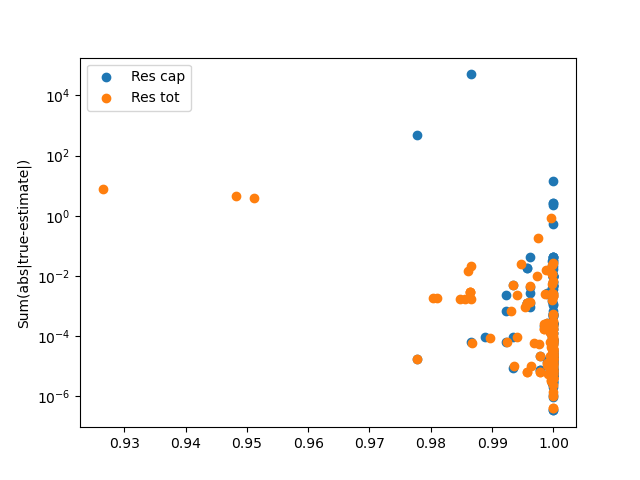

In [33]:
figure()

scatter(sim_cap, cap_residual_cap, label = "Res cap")
scatter(sim_tot, cap_residual_tot, label = "Res tot")
yscale('log')
ylabel("Sum(abs|true-estimate|)")
legend()